# Using complex Memory Schemas for advanced operations (2): Saving memories in collections.
* In the previous exercise learned how to save memories into a single user profile, but what if we want to save memories to a collection rather than single profile? We will learn how to do it in this exercise.

## What is a collection and why we would want to use it?

Let’s clarify what this means step-by-step:

#### Single User Profile
In the previous exercise, we saved all the **memories** (pieces of information) into a **single profile** for one user.  

For example:
- User 1 has a profile with this memory:
  ```
  "User likes learning about French."
  ```
- All the memories are stored **in one place**—just for **one user**.

#### Collection
Now, this exercise is introducing the idea of saving **memories to a collection** instead of tying them to a **single profile**.  

A **collection** is like a **folder** or a **database** that can store **memories for multiple users**.

Example:
- Memory collection for **User 1**:
  ```
  ["User likes learning about French.", "User prefers online courses."]
  ```

- Memory collection for **User 2**:  
  ```
  ["User wants to learn Spanish.", "User prefers in-person classes."]
  ```

#### Key Difference
- **Single Profile:** Stores memories for **one user only**.  
- **Collection:** Stores **memories for multiple users** or **multiple topics** in an organized way.

#### Why Use a Collection?
A collection makes it easier to:
1. Store memories for **multiple users**.  
2. **Retrieve specific memories** for a given user.  
3. **Scale the system** as more users or memories are added.  

#### Analogy
- **Single Profile** = A notebook for **one student**.  
- **Collection** = A **bookshelf** with separate notebooks for **many students**.

This approach is useful when your app or system needs to handle **more than one user** or **more complex data**.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 027-collection-schema.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

We will call our LangSmith project **001-langgraph**.

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Our goal: store the memories about user interactions in a collection
* Instead of storing the user information in a fixed profile structure, we want to create a **flexible collection schema** to store memories about user interactions.
    * Each memory will be stored as a separate entry with a single `content` field for the main information we want to remember.
* This approach allows us to build an open-ended collection of memories that **can grow and change as we learn more about the user**.

## Let's start by defining the collection schema

In [6]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

## OK. Let's review what we just did

The previous code defines two classes using **Pydantic**, a Python library for data validation and settings management. Here's a simple explanation:  

#### Class `Memory`
- Represents a **single piece of information** (memory) about the user.  
- Contains **one attribute**:  
  - **`content`** (a string) – Stores the actual memory, like "User wants to learn French."  
  - Includes a **description** to explain what this field is used for.  

#### Class `MemoryCollection`:
- Represents a **collection of memories** about the user.  
- Contains **one attribute**:  
  - **`memories`** – A **list of `Memory` objects** to store multiple pieces of information about the user.  
  - Also has a **description** explaining its purpose.  

#### Why Use Pydantic?
- **Validation:** Ensures data follows the expected format (e.g., `content` must be a string).  
- **Documentation:** Automatically generates clear documentation for the data model.  

#### Example Usage

```python
# Create a single memory
memory1 = Memory(content="User expressed interest in learning about French.")

# Create another memory
memory2 = Memory(content="User likes online courses.")

# Collect memories into a list
memory_collection = MemoryCollection(memories=[memory1, memory2])

# Access data
print(memory_collection.memories[0].content)  # Output: User expressed interest in learning about French.
```

## Now that we have defined the collection schema, let's check it out with a simple chatbot
* We will use a chatbot with structured output like the one we used in the last exercise.

In [7]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Julio. I like to drive my vespa in SF.")])
memory_collection.memories

[Memory(content="User's name is Julio."),
 Memory(content='Julio likes to drive his vespa in San Francisco.')]

## OK. Let's now save the memory.

In [8]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

## Finally, let's confirm we can retrieve it

In [9]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'content': "User's name is Julio."}, 'key': '02ae72a3-7e7f-4020-9a74-3ebc8008590e', 'namespace': ['1', 'memories'], 'created_at': '2025-01-07T16:18:25.875274+00:00', 'updated_at': '2025-01-07T16:18:25.875280+00:00', 'score': None}
{'value': {'content': 'Julio likes to drive his vespa in San Francisco.'}, 'key': '917a1e65-d413-404f-a74f-432c0c55a6d4', 'namespace': ['1', 'memories'], 'created_at': '2025-01-07T16:18:25.875489+00:00', 'updated_at': '2025-01-07T16:18:25.875490+00:00', 'score': None}


## Good. Let's review what we just did.

The previous code builds on the previous example and demonstrates how to **generate structured data**, **store it in memory**, and **retrieve it later**. Here's a simple explanation:

#### Import Libraries and Setup the Model 
```python
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
```
- Imports tools for working with chat messages and OpenAI's GPT models.  

```python
model = ChatOpenAI(model="gpt-4o", temperature=0)
```
- Initializes the GPT-4o model with a temperature of **0** (ensures deterministic outputs).  


#### Bind Schema to the Model
```python
model_with_structure = model.with_structured_output(MemoryCollection)
```
- Configures the model to produce output in the format defined by the **`MemoryCollection`** schema created earlier.  
- This ensures responses are **structured** and can be easily processed.  


#### Generate Structured Output 
```python
memory_collection = model_with_structure.invoke(
    [HumanMessage("My name is Julio. I like to drive my vespa in SF.")]
)
memory_collection.memories
```
- Sends a **user message** to the model and asks it to generate a structured response.  
- The output is stored as a **`MemoryCollection`** object, following the schema defined earlier.  
- For example:
  - Memory 1: `"My name is Julio."`  
  - Memory 2: `"I like to drive my vespa in SF."`  


#### Import and Setup In-Memory Storage
```python
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()
```
- Imports tools for **in-memory storage** (temporary storage for fast access).  
- Creates a storage instance (`in_memory_store`) to save and manage memories.  


#### Save Memories in Storage  
```python
user_id = "1"
namespace_for_memory = (user_id, "memories")
```
- Defines a **namespace** (like a folder) using a **user ID** and the label `"memories"`.  
- This organizes memories by user and type.  

```python
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)
```
- Generates a **unique key** for each memory using `uuid`.  
- Converts each memory into a **dictionary format** for storage.  
- Saves the memory in the namespace with its key and value. 


#### Search and Retrieve Memories
```python
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())
```
- Searches for all memories stored in the namespace.  
- Prints them as dictionaries, making them easy to read or process further.


#### Example Output  
```
{'content': 'My name is Julio.'}
{'content': 'I like to drive my vespa in SF.'}
```

## Adding and editing memories in the collection using TrustCall
* Remember that in the last exercise we learned how to use TrustCall.
* We will use it again here to add and edit the memories in our collection.
* As you see below, we will set `enable_inserts=True` to allow the TrustCall extractor to insert new memories to the collection.

In [10]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Julio."), 
                AIMessage(content="Nice to meet you, Julio."), 
                HumanMessage(content="This morning I had a nice vespa ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [12]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_Zq95MSs0HxLY2V3CZoLRDswM)
 Call ID: call_Zq95MSs0HxLY2V3CZoLRDswM
  Args:
    content: Julio had a nice vespa ride in San Francisco this morning.


In [13]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Julio had a nice vespa ride in San Francisco this morning.'


In [14]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_Zq95MSs0HxLY2V3CZoLRDswM'}


In [15]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, what did you do after?"), 
                        HumanMessage(content="I went to Whole Foods and bought a green pie soup."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my trip to Carmel, and going back this weekend."),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Julio had a nice vespa ride in San Francisco this morning.'})]

In [16]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [17]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_G5ZsqCzkpJLnocBmTKvp4LlK)
 Call ID: call_G5ZsqCzkpJLnocBmTKvp4LlK
  Args:
    content: Julio had a nice vespa ride in San Francisco this morning. Then, he went to Whole Foods and bought a green pie soup.
  Memory (call_aZ0NAlikwEv4USQVxk1f7Ytj)
 Call ID: call_aZ0NAlikwEv4USQVxk1f7Ytj
  Args:
    content: Julio was thinking about his trip to Carmel and considering going back this weekend.


In [18]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Julio had a nice vespa ride in San Francisco this morning. Then, he went to Whole Foods and bought a green pie soup.'
content='Julio was thinking about his trip to Carmel and considering going back this weekend.'


In [19]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_G5ZsqCzkpJLnocBmTKvp4LlK', 'json_doc_id': '0'}
{'id': 'call_aZ0NAlikwEv4USQVxk1f7Ytj'}


## Let's review what we just did

The previous code demonstrates how to use **TrustCall** to **extract, edit, and add memories** from a conversation using a structured format. Here's a simplified explanation step-by-step:

#### Import TrustCall and Create an Extractor  
```python
from trustcall import create_extractor
```
- Imports the **TrustCall library**, which helps extract structured information from text.  

```python
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)
```
- **Creates an extractor** tied to the GPT model.  
- **`tools=[Memory]`:** Specifies that the output should match the **`Memory` schema** defined earlier.  
- **`tool_choice="Memory"`:** Ensures the extractor always uses the **`Memory` tool** to generate structured outputs.  
- **`enable_inserts=True`:** Allows adding **new memories** to the collection during updates.  


#### Provide Instructions and Initial Conversation
```python
instruction = """Extract memories from the following conversation:"""
```
- Provides **instructions** to the extractor, asking it to **identify relevant memories** from a conversation.  

```python
conversation = [HumanMessage(content="Hi, I'm Julio."), 
                AIMessage(content="Nice to meet you, Julio."), 
                HumanMessage(content="This morning I had a nice vespa ride in San Francisco.")]
```
- Represents the initial **conversation history** as a list of messages.  
- **HumanMessage** and **AIMessage** distinguish between user and AI messages.  


#### Extract Memories from the Conversation 
```python
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})
```
- Combines the **instruction** and **conversation** into a **single input** for the extractor.  
- The extractor **analyzes the messages** and generates structured memories based on the schema.  

```python
for m in result["messages"]:
    m.pretty_print()
```
- Prints **intermediate steps** showing how the extractor interpreted the input.  

```python
for m in result["responses"]: 
    print(m)
```
- Displays the **final extracted memories** that match the schema, e.g.:  
  - **Memory 1:** `"Hi, I'm Julio."`  
  - **Memory 2:** `"I had a nice vespa ride in San Francisco."`  

```python
for m in result["response_metadata"]: 
    print(m)
```
- Outputs **metadata**, such as which tool (schema) was used and how the memories were processed.  


#### Update the Conversation and Memories  

**New Conversation:**  
```python
updated_conversation = [AIMessage(content="That's great, what did you do after?"), 
                        HumanMessage(content="I went to Whole Foods and bought a green pie soup."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my trip to Carmel, and going back this weekend.")]
```
- Adds **new context** to the conversation for further memory extraction or updates.  

**Update Instruction:**
```python
system_msg = """Update existing memories and create new ones based on the following conversation:"""
```
- Updates the **instruction**, asking the extractor to **modify existing memories** or **add new ones** based on the updated conversation.  

**Save Existing Memories:**
```python
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
```
- Prepares **existing memories** for the extractor, converting them into a format that includes:  
  - **ID** (e.g., memory 0, memory 1).  
  - **Tool name** (e.g., "Memory").  
  - **Value** (the actual memory content).  


#### Update Memories Using TrustCall
```python
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})
```
- Processes the updated conversation along with the **existing memories** to:  
  1. **Edit old memories** if necessary.  
  2. **Insert new memories** based on the updated context.  

**Inspect Results:** 
```python
for m in result["messages"]:
    m.pretty_print()
```
- Shows **details of the updates** made to the memories.  

```python
for m in result["responses"]: 
    print(m)
```
- Displays the **new and updated memories** in the structured format.  
  - **Memory 1:** `"Julio went to Whole Foods and bought a green pie soup."`  
  - **Memory 2:** `"Julio is planning a trip to Carmel this weekend."`  

```python
for m in result["response_metadata"]: 
    print(m)
```
- Outputs **metadata** about the changes made (e.g., insertions, updates).  


#### Example Output for Updated Memories
```
{'content': "Julio went to Whole Foods and bought a green pie soup."}
{'content': "Julio is planning a trip to Carmel this weekend."}
```

## OK, now let's try this approach with the chatbot we built in the last exercise

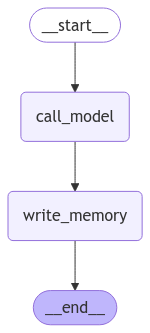

In [20]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [21]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Julio")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Julio
================================== Ai Message ==================================

Hi Julio! It's great to meet you. How can I assist you today?


In [22]:
# User input 
input_messages = [HumanMessage(content="I like to drive my vespa around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to drive my vespa around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun! San Francisco must be a great place to explore on a Vespa with all its unique neighborhoods and scenic views. Do you have any favorite spots you like to visit?


In [23]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'value': {'content': "User's name is Julio."}, 'key': '173a1f17-2308-4f16-bb04-9e20ea2f87fc', 'namespace': ['memories', '1'], 'created_at': '2025-01-08T09:19:09.245031+00:00', 'updated_at': '2025-01-08T09:19:09.245032+00:00', 'score': None}
{'value': {'content': 'User likes to drive their Vespa around San Francisco.'}, 'key': '75e9347b-19d7-462b-a662-114209d76729', 'namespace': ['memories', '1'], 'created_at': '2025-01-08T09:19:34.470361+00:00', 'updated_at': '2025-01-08T09:19:34.470364+00:00', 'score': None}


In [24]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to Whole Foods")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to Whole Foods
================================== Ai Message ==================================

Whole Foods is a great place for fresh and organic groceries. Do you have any favorite items you like to pick up when you're there?


#### Pay attention: now we will continue the conversation with a new thread

In [25]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What do you recommend for me to buy in Whole Foods?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What do you recommend for me to buy in Whole Foods?
================================== Ai Message ==================================

Since you enjoy going to Whole Foods, you might want to explore some of their fresh produce or organic options. If you're looking for something new, you could try their seasonal fruits and vegetables, or perhaps check out their selection of artisanal cheeses and freshly baked bread. If you're into cooking, their spice and herb section is also worth a look. Do you have any specific preferences or dietary needs?


In [26]:
# PAY ATTENTION HERE: see how the second threat
# is also saved in the user memory.
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'value': {'content': "User's name is Julio."}, 'key': '173a1f17-2308-4f16-bb04-9e20ea2f87fc', 'namespace': ['memories', '1'], 'created_at': '2025-01-08T09:19:09.245031+00:00', 'updated_at': '2025-01-08T09:19:09.245032+00:00', 'score': None}
{'value': {'content': 'User likes to drive their Vespa around San Francisco.'}, 'key': '75e9347b-19d7-462b-a662-114209d76729', 'namespace': ['memories', '1'], 'created_at': '2025-01-08T09:19:34.470361+00:00', 'updated_at': '2025-01-08T09:19:34.470364+00:00', 'score': None}
{'value': {'content': 'User enjoys going to Whole Foods.'}, 'key': '55ba8966-aee1-4582-aa9a-9fe2250a3ade', 'namespace': ['memories', '1'], 'created_at': '2025-01-08T09:20:22.873059+00:00', 'updated_at': '2025-01-08T09:20:22.873061+00:00', 'score': None}
{'value': {'content': 'User is interested in recommendations for purchases at Whole Foods.'}, 'key': '0e3e60e8-adbb-4818-8af4-c4feadca4592', 'namespace': ['memories', '1'], 'created_at': '2025-01-08T09:22:44.080135+00:00', 'update

## OK. Let's review what we just did

The previous code demonstrates how to create an **AI chatbot with long-term memory** using **LangGraph** and **TrustCall**. The chatbot can **extract, store, update, and use memories** from conversations to make interactions more personalized. Here's a **simplified explanation**:


#### 1. Key Components

**1.1 Memory Schema**
```python
class Memory(BaseModel):
    content: str = Field(description="Stores user information.")
```
- Defines a **memory structure** to store important user details (e.g., "Julio likes driving a vespa").  


**1.2 TrustCall Extractor**
```python
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)
```
- Uses **TrustCall** to **extract and update memories** from conversations.  
- **`enable_inserts=True`:** Allows adding **new memories** without deleting old ones.  


**1.3 Instructions for AI Behavior**
```python
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You have a long-term memory for user details."""
TRUSTCALL_INSTRUCTION = """Reflect on the conversation and update or insert new memories."""
```
- Guides the AI model to:
  1. **Use memories** in its responses.  
  2. **Update or create memories** after each interaction.  

#### 2. Memory Handling Functions

**2.1 Respond with Memory Context**
```python
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}
```
- **Loads stored memories** for the user.  
- **Personalizes responses** by including relevant memories (e.g., "Julio likes vespa rides").  


**2.2 Update Memories**
```python
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    existing_items = store.search(namespace)

    tool_name = "Memory"
    existing_memories = ([(item.key, tool_name, item.value) for item in existing_items] if existing_items else None)

    updated_messages = list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))
    result = trustcall_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))
```
- **Analyzes chat history** to extract new or updated memories.  
- **Stores them** in memory for future use.  


#### 3. Build the Chatbot Flow

**3.1 Create Graph for Conversation Flow**
```python
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)
```
- **Defines the flow** of the chatbot:  
  1. Responds based on memory.  
  2. Updates or inserts new memories after the response.  


**3.2 Configure Memory Storage**
```python
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)
```
- **Short-term memory:** Tracks chat history during the session.  
- **Long-term memory:** Stores important user details for future sessions.  


#### 4. Interactions and Memory Usage

**4.1 Input Messages**
```python
input_messages = [HumanMessage(content="Hi, my name is Julio")]
```
- The user introduces themselves, and this detail is **saved as memory**.  

**4.2 Process and Respond**
```python
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
```
- **Sends user input** through the chatbot flow.  
- **Stores memory:** "User's name is Julio."  


**4.3 Store and Retrieve Memories**
```python
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())
```
- **Retrieves stored memories** and prints them:
  ```
  {'content': 'User's name is Julio.'}
  ```


**4.4 Continue Conversations**
```python
input_messages = [HumanMessage(content="I like to drive my vespa around San Francisco")]
```
- Adds more user details, saved as:
  ```
  {'content': 'User likes to drive a vespa around San Francisco.'}
  ```

**4.5 Switch Contexts**
```python
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
```
- **Switches conversation context** (e.g., different topic or session) while still **using stored memories** about Julio.  


#### 5. Example Output

**User Messages:**
1. "Hi, my name is Julio."  
2. "I like to drive my vespa around San Francisco."  
3. "I also enjoy going to Whole Foods."  


**Stored Memories:**
```
{'content': "User's name is Julio."}
{'content': "User likes to drive a vespa around San Francisco."}
{'content': "User enjoys going to Whole Foods."}
```


**Next Interaction:**
User Input: 
"What do you recommend for me to buy in Whole Foods?"  

Response (Personalized): 
"Since you enjoy Whole Foods, you might like their organic soups or healthy snacks. Have you tried their green pie soup?"  

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 027-collection-schema.py
* In terminal, make sure you are in the directory of the file and run:
    * python 027-collection-schema.py